In [1]:
from pymatgen.core import Structure
import json

# Load from JSON
with open("sqs_structures.json", "r") as f:
    sqs_structures = json.load(f)

# Convert structure_dict back into Structure objects
sqs_structures = {frac: Structure.from_dict(struct_dict)
                      for frac, struct_dict in sqs_structures.items()}

In [2]:
# Manually select the desired fractions (as strings)
selected_keys = [
    '0.0', '0.1', '0.2', '0.30000000000000004', '0.4',
    '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9'
]

# Filter to only those present in sqs_structures
selected_keys = [k for k in selected_keys if k in sqs_structures]

selected_structures = {k: sqs_structures[k] for k in selected_keys}

In [3]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
# Dictionary to store the results
mlp_elastic_moduli = {}

for name, pmg_struct in tqdm(selected_structures.items()):
    # Convert to ASE Atoms
    atoms = AseAtomsAdaptor.get_atoms(pmg_struct)
    
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa/bulk_gpa

    # Extract elastic constants
    elastic_tensor_6_6 = results['elastic_tensor'].voigt * ev_to_gpa
    c11 = elastic_tensor_6_6[0][0]
    c12 = elastic_tensor_6_6[0][1]
    c44 = elastic_tensor_6_6[3][3]
    # Store in dictionary
    mlp_elastic_moduli[name] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
        'c11': c11,
        'c12': c12,
        'c44': c44
    }
    print(f"{name}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}")

W1023 22:21:27.172000 3663 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
  0%|          | 0/10 [00:00<?, ?it/s]

21
Number of Deformations:  24
3
0
0
3
2
0
0
2
2
0
0
2
4
2
1
4
4
3
3
4
5
3
3
4


 10%|█         | 1/10 [03:29<31:21, 209.09s/it]

0.0: Shear = 49.11 GPa, Bulk = 187.34 GPa, Pugh Ratio = 0.26
35
Number of Deformations:  24
8
3
3
5
4
3
3
4
4
3
3
4
4
3
3
4
4
3
2
4
4
3
3
4


 20%|██        | 2/10 [06:28<25:33, 191.64s/it]

0.1: Shear = 52.83 GPa, Bulk = 197.23 GPa, Pugh Ratio = 0.27
34
Number of Deformations:  24
10
3
3
4
6
3
3
4
6
3
3
4
4
3
3
4
4
3
3
4
4
3
3
4


 30%|███       | 3/10 [08:54<19:54, 170.66s/it]

0.2: Shear = 55.97 GPa, Bulk = 207.10 GPa, Pugh Ratio = 0.27
40
Number of Deformations:  24
9
4
3
5
10
4
3
4
8
3
3
4
4
3
3
4
10
3
3
10
4
3
3
4


 40%|████      | 4/10 [11:44<17:02, 170.34s/it]

0.30000000000000004: Shear = 61.29 GPa, Bulk = 215.36 GPa, Pugh Ratio = 0.28
45
Number of Deformations:  24
10
3
3
10
10
3
3
10
6
2
3
6
4
3
3
5
5
3
3
4
6
3
2
8


 50%|█████     | 5/10 [14:57<14:53, 178.66s/it]

0.4: Shear = 70.00 GPa, Bulk = 225.36 GPa, Pugh Ratio = 0.31
46
Number of Deformations:  24
3
3
3
3
9
3
4
10
9
3
3
9
4
3
2
3
3
3
2
3
3
3
3
8


 60%|██████    | 6/10 [17:49<11:44, 176.24s/it]

0.5: Shear = 78.20 GPa, Bulk = 236.98 GPa, Pugh Ratio = 0.33
44
Number of Deformations:  24
9
3
3
7
9
3
3
8
9
3
3
8
7
2
2
8
3
2
2
3
3
2
2
3


 70%|███████   | 7/10 [20:43<08:46, 175.56s/it]

0.6000000000000001: Shear = 92.37 GPa, Bulk = 252.33 GPa, Pugh Ratio = 0.37
31
Number of Deformations:  24
9
3
3
9
9
3
3
7
3
2
2
3
3
3
3
12
7
3
3
8
8
3
2
7


 80%|████████  | 8/10 [23:38<05:50, 175.37s/it]

0.7000000000000001: Shear = 107.14 GPa, Bulk = 269.81 GPa, Pugh Ratio = 0.40
37
Number of Deformations:  24
8
3
2
3
5
2
2
3
5
3
2
3
3
2
2
3
3
2
2
3
3
2
2
3


 90%|█████████ | 9/10 [26:01<02:45, 165.36s/it]

0.8: Shear = 123.34 GPa, Bulk = 285.87 GPa, Pugh Ratio = 0.43
31
Number of Deformations:  24
3
1
2
3
2
1
2
3
3
2
1
3
8
2
2
7
4
2
1
3
8
2
2
7


100%|██████████| 10/10 [28:21<00:00, 170.18s/it]

0.9: Shear = 137.03 GPa, Bulk = 294.61 GPa, Pugh Ratio = 0.47


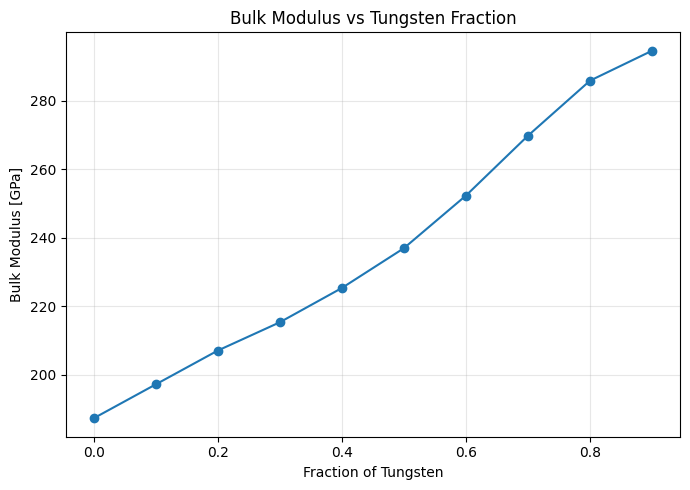

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
fractions = np.array([float(k) for k in mlp_elastic_moduli.keys()])
bulk_modulus = np.array([v['bulk_modulus_vrh'] for v in mlp_elastic_moduli.values()])
shear_modulus = np.array([v['shear_modulus_vrh'] for v in mlp_elastic_moduli.values()])
sqs_c11 = np.array([v['c11'] for v in mlp_elastic_moduli.values()])
sqs_c12 = np.array([v['c12'] for v in mlp_elastic_moduli.values()])
sqs_c44 = np.array([v['c44'] for v in mlp_elastic_moduli.values()])
pugh_ratio = np.array([v['pugh_ratio'] for v in mlp_elastic_moduli.values()])

# Sort by fraction
sort_idx = np.argsort(fractions)
fractions = fractions[sort_idx]
sqs_bulk_modulus = bulk_modulus[sort_idx]
sqs_shear_modulus = shear_modulus[sort_idx]
sqs_pugh_ratio = pugh_ratio[sort_idx]

# Plot Bulk modulus
plt.figure(figsize=(7,5))
plt.plot(fractions, sqs_bulk_modulus, marker='o', label='Bulk modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Bulk Modulus [GPa]')
plt.title('Bulk Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

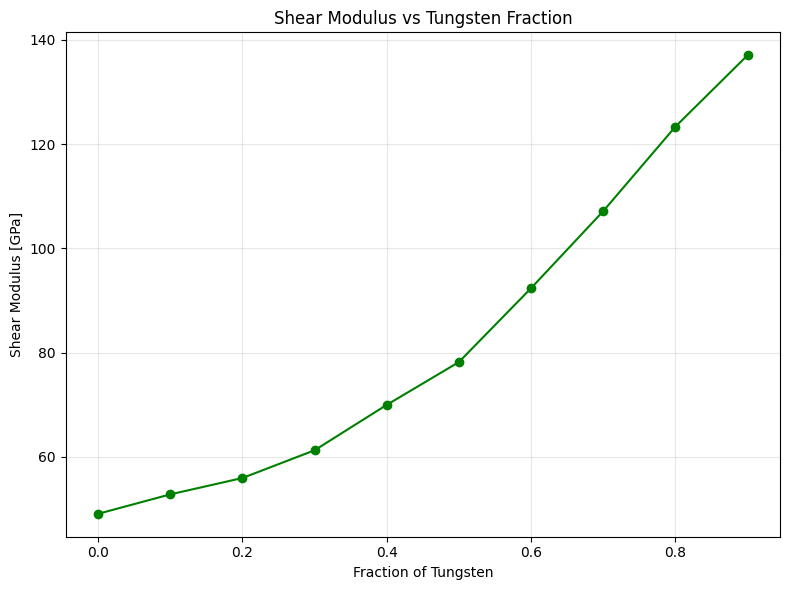

In [7]:
# Plot Shear modulus
plt.figure(figsize=(8,6))
plt.plot(fractions, sqs_shear_modulus, marker='o', color='green', label='Shear modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Shear Modulus [GPa]')
plt.title('Shear Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

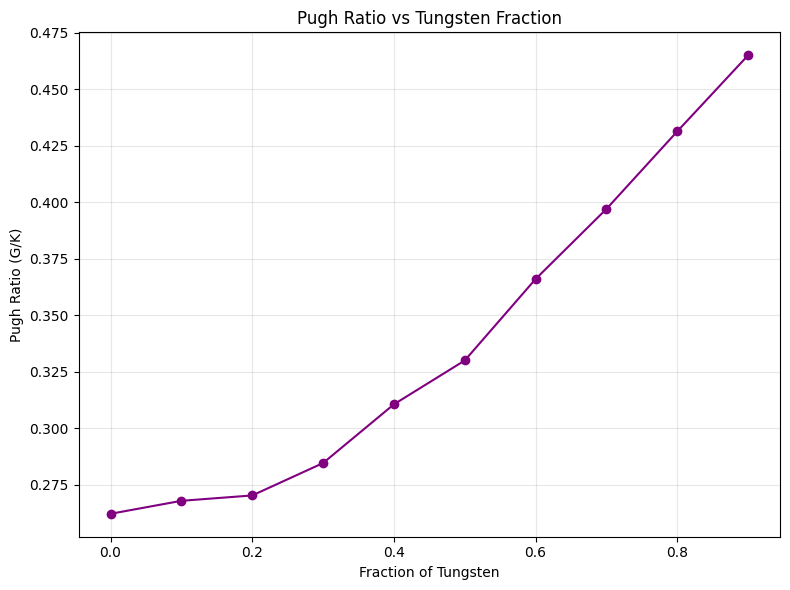

In [8]:
# Plot Pugh ratio
plt.figure(figsize=(8,6))
plt.plot(fractions, sqs_pugh_ratio, marker='o', color='purple', label='Pugh Ratio (G/K)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Pugh Ratio (G/K)')
plt.title('Pugh Ratio vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

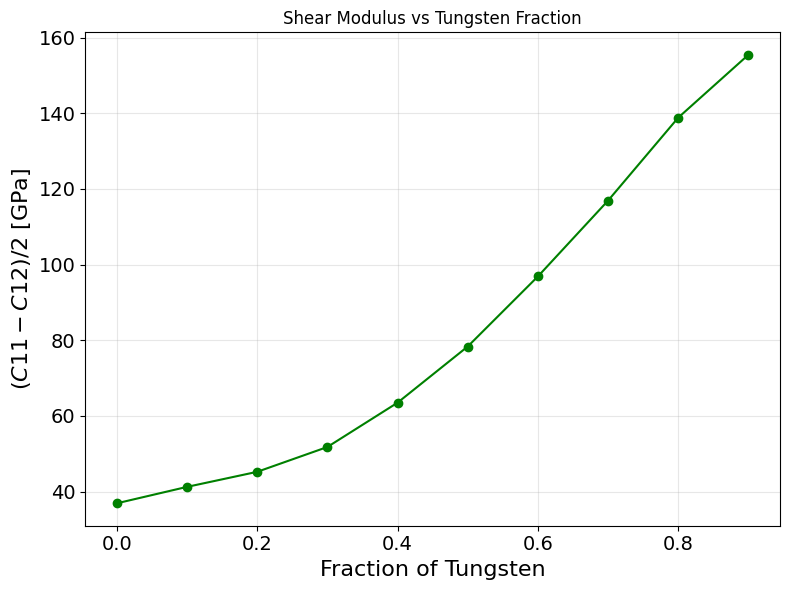

In [9]:
# Plot Shear modulus
plt.figure(figsize=(8,6))
plt.plot(fractions, (sqs_c11 - sqs_c12)/2, marker='o', color='green', label='Shear modulus (VRH)')
plt.xlabel('Fraction of Tungsten', fontsize=16,)
plt.ylabel('$(C11-C12)/2$ [GPa]', fontsize=16,)
plt.title('Shear Modulus vs Tungsten Fraction')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

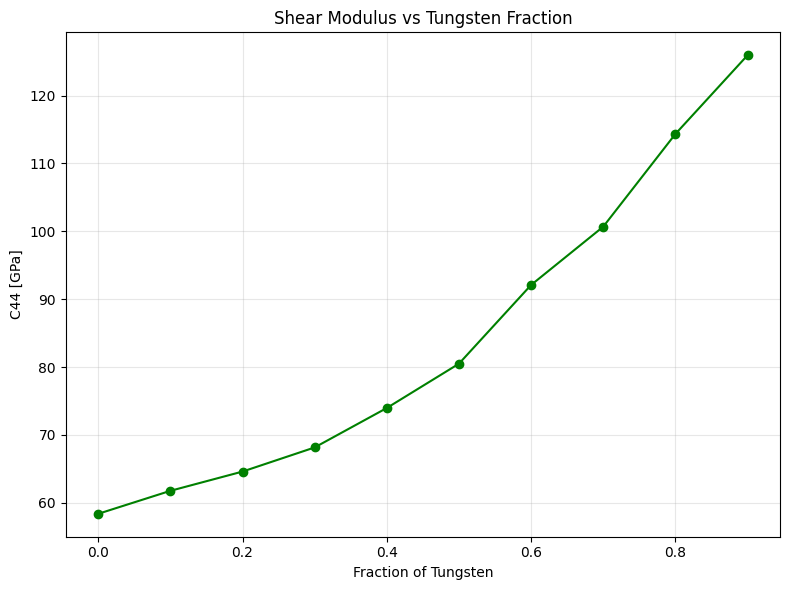

In [10]:
# Plot Shear modulus
plt.figure(figsize=(8,6))
plt.plot(fractions, sqs_c44, marker='o', color='green', label='Shear modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('C44 [GPa]')
plt.title('Shear Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

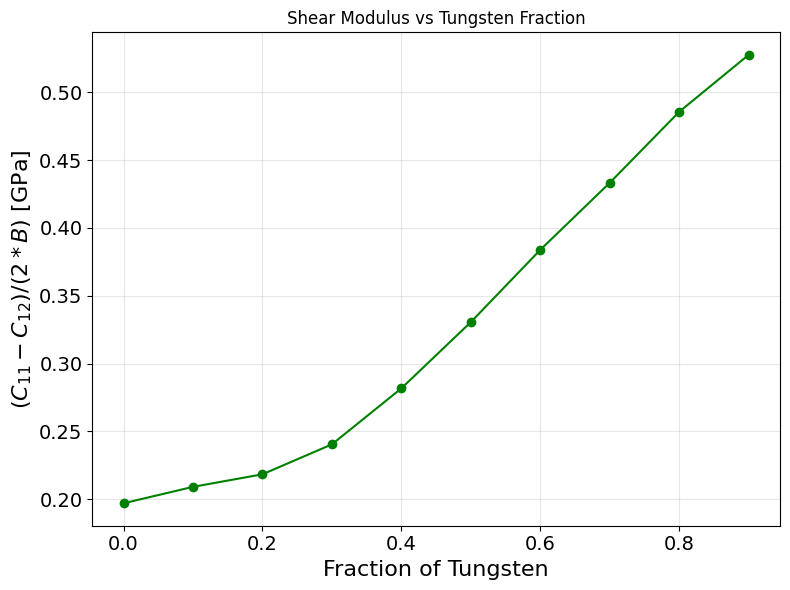

In [11]:
# Plot Shear modulus
plt.figure(figsize=(8,6))
plt.plot(fractions, (sqs_c11 - sqs_c12)/(2*sqs_bulk_modulus), marker='o', color='green', label='Shear modulus (VRH)')
plt.xlabel('Fraction of Tungsten', fontsize=16,)
plt.ylabel('$(C_{11} - C_{12})/(2*B)$ [GPa]', fontsize=16,)
plt.title('Shear Modulus vs Tungsten Fraction')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Compare to the Ordered Structures

In [12]:
import json
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor

# Load from JSON
with open("relaxed_structures_with_energies.json", "r") as f:
    data = json.load(f)

# Reconstruct formation_energies as a list of (ase.Atoms, formation_energy)
formation_energies = []
for entry in data:
    pmg_struct = Structure.from_dict(entry["structure"])
    atoms = AseAtomsAdaptor.get_atoms(pmg_struct)
    formation_energies.append((atoms, entry["formation_energy"]))

In [13]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

lowest_by_comp = defaultdict(lambda: (None, np.inf))

for atoms, E_form in tqdm(formation_energies):
    formula = atoms.get_chemical_formula()
    if E_form < lowest_by_comp[formula][1]:
        lowest_by_comp[formula] = (atoms, E_form)

# print results
for formula, (atoms, E_form) in lowest_by_comp.items():
    print(f"{formula}: lowest formation energy = {E_form:.4f} eV/atom")

100%|██████████| 4764/4764 [00:00<00:00, 109135.75it/s]

NbW9: lowest formation energy = -0.0282 eV/atom
NbTaW8: lowest formation energy = -0.0623 eV/atom
NbTa2W7: lowest formation energy = -0.0827 eV/atom
NbTa3W6: lowest formation energy = -0.0895 eV/atom
NbTa4W5: lowest formation energy = -0.0882 eV/atom
NbTa5W4: lowest formation energy = -0.0799 eV/atom
NbTa6W3: lowest formation energy = -0.0638 eV/atom
NbTa7W2: lowest formation energy = -0.0442 eV/atom
NbTa8W: lowest formation energy = -0.0237 eV/atom
NbTa9: lowest formation energy = -0.0008 eV/atom


In [ ]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
mlp_elastic_moduli = {}

for name, (atoms, E_form) in tqdm(lowest_by_comp.items()):
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
        relax_initial=True,
        relax_strained=True
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa / bulk_gpa
    
    # Extract elastic constants
    elastic_tensor_6_6 = results['elastic_tensor'].voigt * ev_to_gpa
    c11 = elastic_tensor_6_6[0][0]
    c12 = elastic_tensor_6_6[0][1]
    c44 = elastic_tensor_6_6[3][3]
    # Store in dictionary
    mlp_elastic_moduli[name] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
        'c11': c11,
        'c12': c12,
        'c44': c44
    }
    print(f"{name}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}, Formation Energy = {E_form:.4f} eV/atom")

  0%|          | 0/10 [00:00<?, ?it/s]

1
Number of Deformations:  24
2
1
0
1
2
1
0
1
3
2
2
3
2
2
1
1
3
1
1
3
3
1
1
3


 10%|█         | 1/10 [00:44<06:43, 44.79s/it]

NbW9: Shear = 137.91 GPa, Bulk = 295.33 GPa, Pugh Ratio = 0.47, Formation Energy = -0.0282 eV/atom
2
Number of Deformations:  24
2
0
0
2
2
0
0
1
3
2
2
3
3
1
2
3
3
2
2
3
7
2
2
7


 20%|██        | 2/10 [01:31<06:06, 45.87s/it]

NbTaW8: Shear = 125.50 GPa, Bulk = 286.91 GPa, Pugh Ratio = 0.44, Formation Energy = -0.0623 eV/atom
0
Number of Deformations:  24
3
2
0
2
3
2
0
2
6
3
3
3
2
1
2
2
3
1
1
3
3
1
1
3


 30%|███       | 3/10 [02:16<05:19, 45.59s/it]

NbTa2W7: Shear = 109.95 GPa, Bulk = 271.21 GPa, Pugh Ratio = 0.41, Formation Energy = -0.0827 eV/atom
2
Number of Deformations:  24
3
2
2
3
3
3
3
3
3
2
2
3
3
2
2
3
2
0
2
3
3
2
2
3


 40%|████      | 4/10 [03:02<04:35, 45.86s/it]

NbTa3W6: Shear = 95.70 GPa, Bulk = 252.95 GPa, Pugh Ratio = 0.38, Formation Energy = -0.0895 eV/atom
3
Number of Deformations:  24
3
2
2
3
3
2
2
3
3
2
2
3
3
2
2
3
3
2
2
3
3
2
2


 50%|█████     | 5/10 [04:00<04:09, 49.96s/it]

3
NbTa4W5: Shear = 84.37 GPa, Bulk = 239.13 GPa, Pugh Ratio = 0.35, Formation Energy = -0.0882 eV/atom
3
Number of Deformations:  24
4
3
3
4
4
3
3
4
4
3
3
4
3
2
3
4
3
2
3
3
3
2
3


 60%|██████    | 6/10 [04:55<03:26, 51.74s/it]

3
NbTa5W4: Shear = 76.71 GPa, Bulk = 227.28 GPa, Pugh Ratio = 0.34, Formation Energy = -0.0799 eV/atom
4
Number of Deformations:  24
4
3
3
4
4
3
3
4
4
3
3
4
4
2
2
3
3
2
2
3
3
2
2
3


 70%|███████   | 7/10 [05:51<02:39, 53.26s/it]

NbTa6W3: Shear = 68.92 GPa, Bulk = 215.98 GPa, Pugh Ratio = 0.32, Formation Energy = -0.0638 eV/atom
4
Number of Deformations:  24
3
2
3
4
3
2
3
4
8
4
4
4
3
0
1
3
4
3
3
4
4
3
3


 80%|████████  | 8/10 [06:48<01:48, 54.45s/it]

4
NbTa7W2: Shear = 60.57 GPa, Bulk = 205.75 GPa, Pugh Ratio = 0.29, Formation Energy = -0.0442 eV/atom
0
Number of Deformations:  24
4
4
3
4
4
3
4
4
4
2
3
5
4
3
2
3
4
3
2
4
4
3
2
3


 90%|█████████ | 9/10 [07:49<00:56, 56.48s/it]

NbTa8W: Shear = 55.11 GPa, Bulk = 196.63 GPa, Pugh Ratio = 0.28, Formation Energy = -0.0237 eV/atom
4
Number of Deformations:  24
0
0
0
2
2
0
1
3
0
0
0
2
4
2
2
3
4
2
1
3
3
2
0
3


100%|██████████| 10/10 [08:32<00:00, 51.23s/it]

NbTa9: Shear = 49.36 GPa, Bulk = 187.53 GPa, Pugh Ratio = 0.26, Formation Energy = -0.0008 eV/atom


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re

def tungsten_fraction(formula):
    # Extract number after 'W' (or 1 if just 'W')
    match = re.search(r'W(\d*)', formula)
    if match:
        w_count = int(match.group(1)) if match.group(1) else 1
    else:
        w_count = 0
    # Extract all element counts
    counts = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    total = sum(int(n) if n else 1 for el, n in counts)
    return w_count / total if total > 0 else 0

# Prepare data for plotting
fractions = np.array([tungsten_fraction(k) for k in mlp_elastic_moduli.keys()])
bulk_modulus = np.array([v['bulk_modulus_vrh'] for v in mlp_elastic_moduli.values()])
shear_modulus = np.array([v['shear_modulus_vrh'] for v in mlp_elastic_moduli.values()])
pugh_ratio = np.array([v['pugh_ratio'] for v in mlp_elastic_moduli.values()])
c11 = np.array([v['c11'] for v in mlp_elastic_moduli.values()])
c12 = np.array([v['c12'] for v in mlp_elastic_moduli.values()])
c44 = np.array([v['c44'] for v in mlp_elastic_moduli.values()])

# Sort by fraction
sort_idx = np.argsort(fractions)
fractions = fractions[sort_idx]
bulk_modulus = bulk_modulus[sort_idx]
shear_modulus = shear_modulus[sort_idx]
pugh_ratio = pugh_ratio[sort_idx]

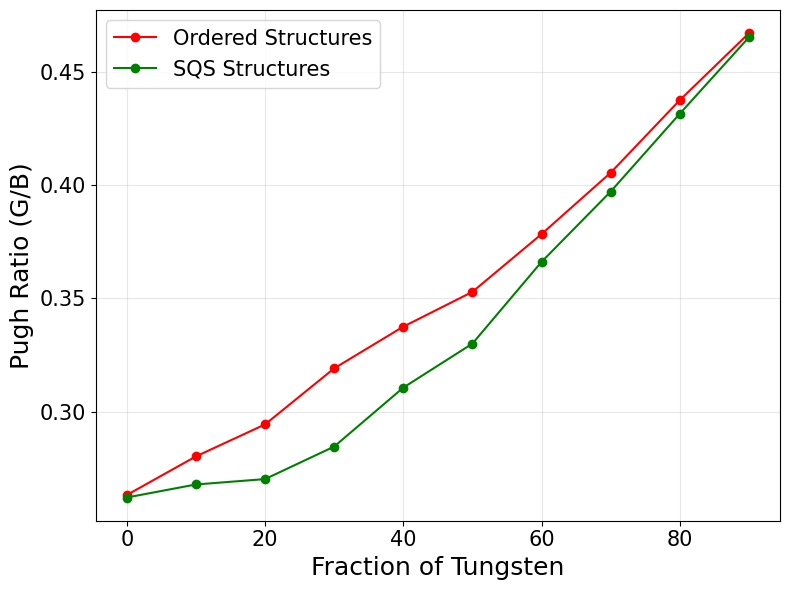

In [17]:
# Plot Pugh ratio vs Tungsten fraction with larger fonts
plt.figure(figsize=(8,6))
plt.plot(fractions*100, pugh_ratio, marker='o', color='red', label='Ordered Structures')
plt.plot(fractions*100, sqs_pugh_ratio, marker='o', color='green', label='SQS Structures')
plt.xlabel('Fraction of Tungsten', fontsize=18)
plt.ylabel('Pugh Ratio (G/B)', fontsize=18)
# plt.title('Pugh Ratio vs Tungsten Fraction', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=15)

In [31]:
dft_shear_ordered = [69.33719079,  73.17408806,  74.05599689,
        70.64606591,  82.16522509, 108.96242166, 118.40812461,
       127.57430535, 138.41214822]
dft_shear_sqs = [ 67.95518848,  69.76589585,  68.36334154,  66.59985088,
        71.31700869,  95.20974769, 117.32207198, 130.41579805,
       141.9883573]

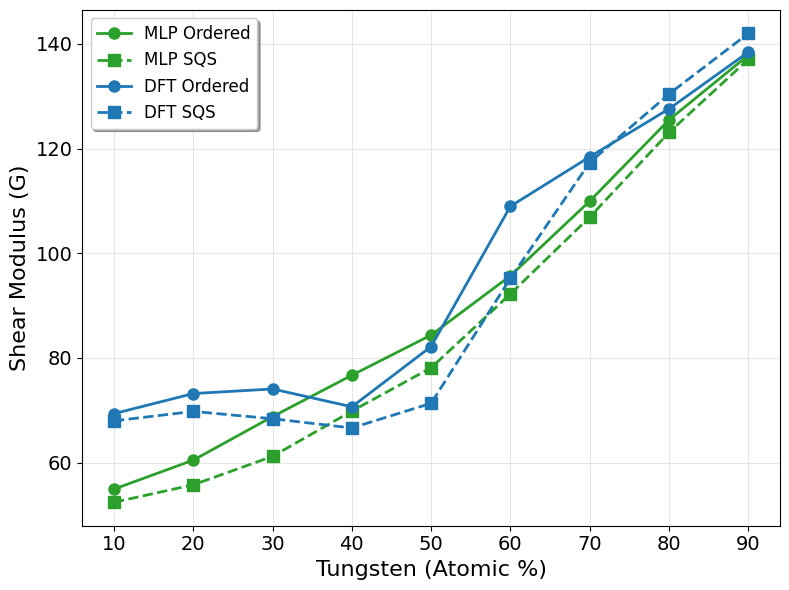

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot MLP Ordered
line1 = ax1.plot(fractions[1:]*100, shear_modulus[1:], 'o-', color='tab:green', 
                 markersize=8, linewidth=2, label='MLP Ordered')

# Plot MLP SQS
line2 = ax1.plot(fractions[1:]*100, sqs_shear_modulus[1:], 's--', color='tab:green', 
                 markersize=8, linewidth=2, label='MLP SQS')

# Plot DFT Ordered
line3 = ax1.plot(fractions[1:]*100, dft_shear_ordered, 'o-', color='tab:blue', 
                 markersize=8, linewidth=2, label='DFT Ordered')

# Plot DFT SQS
line4 = ax1.plot(fractions[1:]*100, dft_shear_sqs, 's--', color='tab:blue', 
                 markersize=8, linewidth=2, label='DFT SQS')

# Axis labels and formatting
ax1.set_xlabel('Tungsten (Atomic %)', fontsize=16)
ax1.set_ylabel('Shear Modulus (G)', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(alpha=0.3)

# Legend styling
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()


In [33]:
dft_bulk_ordered = [ 202.0039267 , 209.59223519, 221.92398501,
       231.64852779, 243.71288174, 256.24226884, 268.4919569 ,
       278.91430963, 290.84692408]
dft_bulk_sqs = [201.26958942, 210.0905843 , 220.55007056, 230.6658093 ,
       242.14940819, 256.10365238, 267.95465001, 279.3376507 ,
       290.7067034]

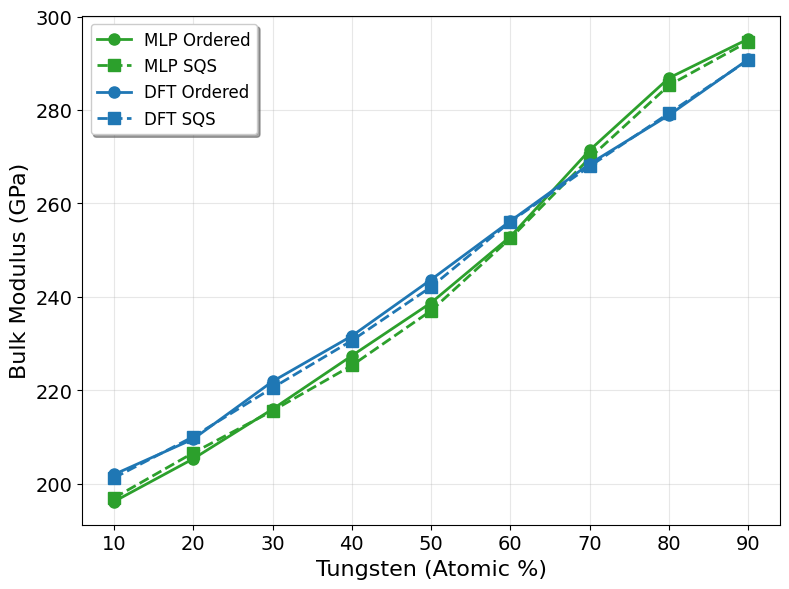

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual variables)
# fractions, bulk_modulus, sqs_bulk_modulus, dft_bulk_ordered, dft_bulk_sqs = ...

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot MLP Ordered
line1 = ax1.plot(fractions[1:]*100, bulk_modulus[1:], 'o-', color='tab:green', 
                 markersize=8, linewidth=2, label='MLP Ordered')

# Plot MLP SQS
line2 = ax1.plot(fractions[1:]*100, sqs_bulk_modulus[1:], 's--', color='tab:green', 
                 markersize=8, linewidth=2, label='MLP SQS')

# Plot DFT Ordered
line3 = ax1.plot(fractions[1:]*100, dft_bulk_ordered, 'o-', color='tab:blue', 
                 markersize=8, linewidth=2, label='DFT Ordered')

# Plot DFT SQS
line4 = ax1.plot(fractions[1:]*100, dft_bulk_sqs, 's--', color='tab:blue', 
                 markersize=8, linewidth=2, label='DFT SQS')

# Axis labels and styling
ax1.set_xlabel('Tungsten (Atomic %)', fontsize=16)
ax1.set_ylabel('Bulk Modulus (GPa)', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax1.grid(alpha=0.3)

# Legend with consistent styling
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()
